In [1]:
import numpy as np  # this module handles arrays, but here we need it for its NaN value
import pandas as pd # this module contains a lot of tools for handling tabular data
from matplotlib import pyplot as plt
from salishsea_tools import evaltools as et
import datetime as dt
import os
import gsw
import pickle
import netCDF4 as nc
import cmocean
from scipy import stats as spst
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

In [2]:
modSourceDir= '/results/SalishSea/nowcast-green.201812/'
modver='201812'
Chl_N=1.8 # Chl:N ratio
fname='compHPLCModelFirstLook-Regress-Base.ipynb'
startYMD=(2015,1,1)
endYMD=(2018,12,31)

In [3]:
# Parameters
modSourceDir = '/data/eolson/results/MEOPAR/SS36runs/GrahamRuns/2018ES_LF/'
modver = '2018ES_LF'
start_date = dt.datetime(2016,1,1)
end_date = dt.datetime(2016, 6, 30)
Chl_N = 1.8
#fname = "compHPLCModelFirstLook-Regress-2018ES_LF-2015.ipynb"


In [4]:
datestr='_'+start_date.strftime('%Y%m%d')+'_'+end_date.strftime('%Y%m%d')

In [5]:
def subval(idf,colList):
    # first value in colList should be the column you are going to keep
    # follow with other columns that will be used to fill in when that column is NaN
    # in order of precedence
    if len(colList)==2:
        idf[colList[0]]=[r[colList[0]] if not pd.isna(r[colList[0]]) \
                         else  r[colList[1]] for i,r in idf.iterrows()]
    elif len(colList)==3:
        idf[colList[0]]=[r[colList[0]] if not pd.isna(r[colList[0]]) \
                         else  r[colList[1]] if not pd.isna(r[colList[1]]) \
                         else r[colList[2]] for i,r in idf.iterrows()]
    else:
        raise NotImplementedError('Add to code to handle this case')
    idf.drop(columns=list(colList[1:]),inplace=True)
    return idf

In [6]:
if os.path.isfile('matched_'+modver+datestr+'.pkl'):
    data=pickle.load(open( 'matched_'+modver+datestr+'.pkl', 'rb' ) )
else:
    # define paths to the source files and eventual output file
    flist=('/ocean/eolson/MEOPAR/obs/NemcekHPLC/bottlePhytoMerged2015.csv',
           '/ocean/eolson/MEOPAR/obs/NemcekHPLC/bottlePhytoMerged2016.csv',
           '/ocean/eolson/MEOPAR/obs/NemcekHPLC/bottlePhytoMerged2017.csv',
           '/ocean/eolson/MEOPAR/obs/NemcekHPLC/bottlePhytoMerged2018.csv')#,
           #'/ocean/eolson/MEOPAR/obs/NemcekHPLC/bottlePhytoMerged2019.csv')

    dfs=list()
    for fname in flist:
        idf=pd.read_csv(fname)
        print(fname,sorted(idf.keys()))
        dfs.append(idf)
    df=pd.concat(dfs,ignore_index=True,sort=False); # concatenate the list into a single table

    df.drop(labels=['ADM:MISSION','ADM:PROJECT','ADM:SCIENTIST','Zone','Zone.1','Temperature:Draw',
                    'Temperature:Draw [deg C (ITS90)]','Bottle:Firing_Sequence','Comments by sample_numbeR',
                    'File Name','LOC:EVENT_NUMBER','Number_of_bin_records'
                       ],axis=1,inplace=True)

    df=subval(df,('Dictyochophytes','Dictyo'))
    df=subval(df,('Chlorophyll:Extracted [mg/m^3]','Chlorophyll:Extracted'))
    df=subval(df,('Dinoflagellates','Dinoflagellates-1'))
    df=subval(df,('Fluorescence [mg/m^3]','Fluorescence:URU:Seapoint [mg/m^3]','Fluorescence:URU:Seapoint'))
    df=subval(df,('Lat','LOC:LATITUDE'))
    df=subval(df,('Lon','LOC:LONGITUDE'))
    df=subval(df,('Nitrate_plus_Nitrite [umol/L]','Nitrate_plus_Nitrite'))
    df=subval(df,('PAR [uE/m^2/sec]','PAR'))
    df=subval(df,('Phaeo-Pigment:Extracted [mg/m^3]','Phaeo-Pigment:Extracted'))
    df=subval(df,('Phosphate [umol/L]','Phosphate'))
    df=subval(df,('Pressure [decibar]','Pressure'))
    df=subval(df,('Raphidophytes','Raphido'))
    df=subval(df,('Salinity','Salinity [PSS-78]','Salinity:T1:C1 [PSS-78]'))
    df=subval(df,('Salinity:Bottle','Salinity:Bottle [PSS-78]'))
    df=subval(df,('Silicate [umol/L]','Silicate'))
    df=subval(df,('TchlA (ug/L)','TchlA'))
    df=subval(df,('Temperature','Temperature [deg C (ITS90)]','Temperature:Secondary [deg C (ITS90)]'))
    df=subval(df,('Transmissivity [*/metre]','Transmissivity'))

    df['Z']=np.where(pd.isna(df['Depth [metres]']),
                     -1*gsw.z_from_p(df['Pressure [decibar]'],df['Lat']),
                     df['Depth [metres]'])
    df['p']=np.where(pd.isna(df['Pressure [decibar]']),
                     gsw.p_from_z(-1*df['Depth [metres]'],df['Lat']),
                    df['Pressure [decibar]'])
    df['SA']=gsw.SA_from_SP(df['Salinity'],df['p'],df['Lon'],df['Lat'])
    df['CT']=gsw.CT_from_t(df['SA'],df['Temperature'],df['p'])

    df['dtUTC']=[dt.datetime.strptime(ii,'%Y-%m-%d %H:%M:%S') if isinstance(ii,str) else np.nan for ii in df['FIL:START TIME YYYY/MM/DD HH:MM:SS'] ]

    PATH= modSourceDir

    flen=1
    namfmt='nowcast'
    #varmap={'N':'nitrate','Si':'silicon','Ammonium':'ammonium'}
    filemap={'nitrate':'ptrc_T','silicon':'ptrc_T','ammonium':'ptrc_T','diatoms':'ptrc_T','ciliates':'ptrc_T','flagellates':'ptrc_T','vosaline':'grid_T','votemper':'grid_T'}
    #gridmap={'nitrate':'tmask','silicon':'tmask','ammonium':'tmask'}
    fdict={'ptrc_T':1,'grid_T':1}

    data=et.matchData(df,filemap,fdict,start_date,end_date,namfmt,PATH,flen)

    with open('matched_'+modver+datestr+'.pkl','wb') as f:
        pickle.dump(data,f)

In [7]:
data['other']=0.0
for el in ('Cryptophytes', 'Cyanobacteria', 'Dictyochophytes', 'Dinoflagellates',
    'Haptophytes', 'Prasinophytes', 'Raphidophytes'):
    data['other']=data['other']+data[el]

(0, 8)

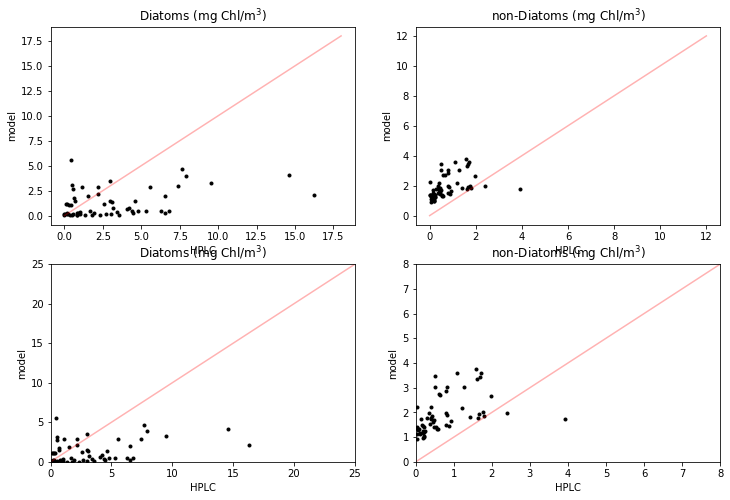

In [8]:
fig,ax=plt.subplots(2,2,figsize=(12,8))
ax=ax.flatten()
ax[0].plot(data['Diatoms-1']+data['Diatoms-2'],Chl_N*data['mod_diatoms'],'k.')
ax[0].set_title('Diatoms (mg Chl/m$^3$)')
ax[0].set_xlabel('HPLC')
ax[0].set_ylabel('model')
ax[0].plot((0,18),(0,18),'r-',alpha=.3)

ax[1].plot(data['other'],Chl_N*(data['mod_flagellates']+data['mod_ciliates']),'k.')
ax[1].set_title('non-Diatoms (mg Chl/m$^3$)')
ax[1].set_xlabel('HPLC')
ax[1].set_ylabel('model')
ax[1].plot((0,12),(0,12),'r-',alpha=.3)

ax[2].plot(data['Diatoms-1']+data['Diatoms-2'],Chl_N*data['mod_diatoms'],'k.')
ax[2].set_title('Diatoms (mg Chl/m$^3$)')
ax[2].set_xlabel('HPLC')
ax[2].set_ylabel('model')
ax[2].plot((0,25),(0,25),'r-',alpha=.3)
ax[2].set_xlim((0,25))
ax[2].set_ylim((0,25))

ax[3].plot(data['other'],Chl_N*(data['mod_flagellates']+data['mod_ciliates']),'k.')
ax[3].set_title('non-Diatoms (mg Chl/m$^3$)')
ax[3].set_xlabel('HPLC')
ax[3].set_ylabel('model')
ax[3].plot((0,12),(0,12),'r-',alpha=.3)
ax[3].set_xlim((0,8))
ax[3].set_ylim((0,8))

In [9]:
def logt(x):
    return np.log10(x+.001)

(-3.1, 2)

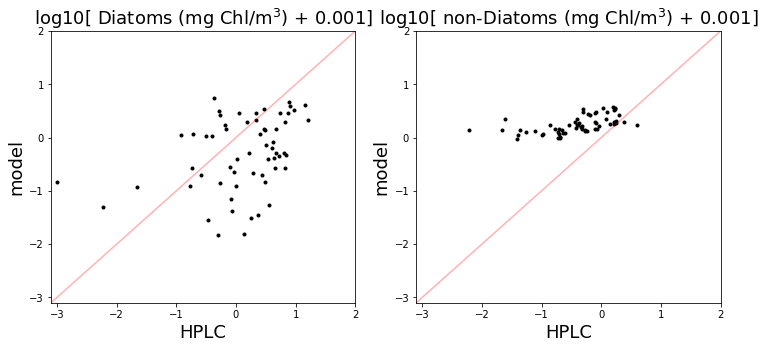

In [10]:
fig,ax=plt.subplots(1,2,figsize=(12,5))
ax[0].plot(logt(data['Diatoms-1']+data['Diatoms-2']),logt(Chl_N*data['mod_diatoms']),'k.')
ax[0].set_title('log10[ Diatoms (mg Chl/m$^3$) + 0.001]',fontsize=18)
ax[0].set_xlabel('HPLC',fontsize=18)
ax[0].set_ylabel('model',fontsize=18)
ax[0].set_xlim(-3.1,2)
ax[0].set_ylim(-3.1,2)
ax[0].plot((-6,3),(-6,3),'r-',alpha=.3)

ax[1].plot(logt(data['other']),logt(Chl_N*(data['mod_flagellates']+data['mod_ciliates'])),'k.')
ax[1].set_title('log10[ non-Diatoms (mg Chl/m$^3$) + 0.001]',fontsize=18)
ax[1].set_xlabel('HPLC',fontsize=18)
ax[1].set_ylabel('model',fontsize=18)
ax[1].plot((-6,3),(-6,3),'r-',alpha=.3)
ax[1].set_xlim(-3.1,2)
ax[1].set_ylim(-3.1,2)

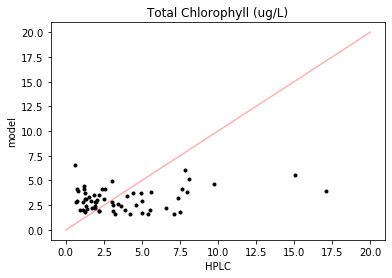

In [11]:
plt.plot(data['TchlA (ug/L)'],Chl_N*(data['mod_flagellates']+data['mod_ciliates']+data['mod_diatoms']),'k.')
plt.title('Total Chlorophyll (ug/L)')
plt.xlabel('HPLC')
plt.ylabel('model')
plt.plot((0,20),(0,20),'r-',alpha=.3)

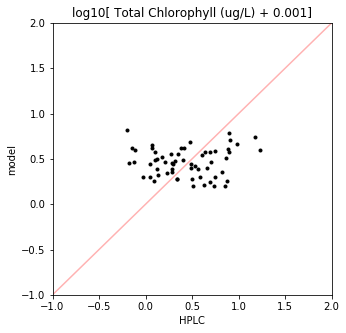

In [12]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.plot(logt(data['TchlA (ug/L)']),logt(Chl_N*(data['mod_flagellates']+data['mod_ciliates']+data['mod_diatoms'])),'k.')
ax.set_title('log10[ Total Chlorophyll (ug/L) + 0.001]')
ax.set_xlabel('HPLC')
ax.set_ylabel('model')
ax.plot((-6,5),(-6,5),'r-',alpha=.3)
ax.set_xlim(-1,2)
ax.set_ylim(-1,2);

In [13]:
def yd(idt):
    if type(idt)==dt.datetime:
        yd=(idt-dt.datetime(idt.year-1,12,31)).days
    else: # assume array or pandas
        yd=[(ii-dt.datetime(ii.year-1,12,31)).days for ii in idt]
    return yd

data['yd']=yd(data['dtUTC'])
data['Year']=[ii.year for ii in data['dtUTC']]

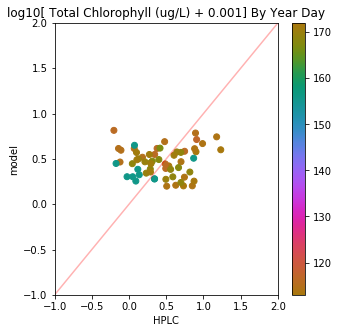

In [14]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
m=ax.scatter(logt(data['TchlA (ug/L)']),logt(Chl_N*(data['mod_flagellates']+data['mod_ciliates']+data['mod_diatoms'])),
          c=data['yd'],cmap=cmocean.cm.phase)
ax.set_title('log10[ Total Chlorophyll (ug/L) + 0.001] By Year Day')
ax.set_xlabel('HPLC')
ax.set_ylabel('model')
ax.plot((-6,5),(-6,5),'r-',alpha=.3)
ax.set_xlim(-1,2)
ax.set_ylim(-1,2);
fig.colorbar(m)

In [15]:
with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as mesh:
    tmask=np.copy(mesh.variables['tmask'][0,:,:,:])
    navlat=np.copy(mesh.variables['nav_lat'][:,:])
    navlon=np.copy(mesh.variables['nav_lon'][:,:])

## Multiple Linear Regression

#### Diatoms

In [16]:
ii=(~pd.isnull(data['mod_diatoms']))&(~pd.isnull(data['Diatoms-1']))&(~pd.isnull(data['Diatoms-2']))&(~pd.isnull(data['Cyanobacteria']))&\
        (~pd.isnull(data['Cryptophytes']))&(~pd.isnull(data['Prasinophytes']))&(~pd.isnull(data['Haptophytes']))&\
        (~pd.isnull(data['Dictyochophytes']))&(~pd.isnull(data['Dinoflagellates']))&(~pd.isnull(data['Raphidophytes']))
A=np.vstack([data.loc[ii]['Diatoms-1'],data.loc[ii]['Diatoms-2'],data.loc[ii]['Cyanobacteria'],data.loc[ii]['Cryptophytes'],
               data.loc[ii]['Prasinophytes'],data.loc[ii]['Haptophytes'],data.loc[ii]['Dictyochophytes'],data.loc[ii]['Dinoflagellates'],
             data.loc[ii]['Raphidophytes'],np.ones(np.shape(data.loc[ii]['Diatoms-1']))]).T
b=data.loc[ii]['mod_diatoms']
m=np.linalg.lstsq(A,b,rcond=None)[0]

In [17]:
m

array([  0.08362105,   0.22535851, -12.38483591,  -0.35994327,
        -1.40883804,  -0.17590896,  -0.34831558,  -0.44065709,
         2.3901134 ,   0.76117762])

In [18]:
clist=('Diatoms-1','Diatoms-2','Cyanobacteria','Cryptophytes','Prasinophytes','Haptophytes',
        'Dictyochophytes','Dinoflagellates','Raphidophytes','ones')
for c, mm in zip(clist,m):
    print(c,mm)

Diatoms-1 0.0836210540016531
Diatoms-2 0.22535851473066304
Cyanobacteria -12.384835913666327
Cryptophytes -0.3599432699259331
Prasinophytes -1.4088380417668582
Haptophytes -0.1759089616388898
Dictyochophytes -0.3483155836539772
Dinoflagellates -0.44065709437184625
Raphidophytes 2.3901134020318398
ones 0.7611776183934416


In [19]:
ii=(~pd.isnull(data['mod_diatoms']))&(~pd.isnull(data['Diatoms-1']))&(~pd.isnull(data['Diatoms-2']))&\
        (~pd.isnull(data['Cryptophytes']))&(~pd.isnull(data['Raphidophytes']))
A=np.vstack([data.loc[ii]['Diatoms-1'],data.loc[ii]['Diatoms-2'],data.loc[ii]['Cryptophytes'],
            data.loc[ii]['Raphidophytes'],np.ones(np.shape(data.loc[ii]['Diatoms-1']))]).T
b=data.loc[ii]['mod_diatoms']
m=np.linalg.lstsq(A,b,rcond=None)[0]

In [20]:
clist=('Diatoms-1','Diatoms-2','Cryptophytes','Raphidophytes','ones')
for c, mm in zip(clist,m):
    print(c,mm)

Diatoms-1 0.08282683892836394
Diatoms-2 0.1091724649178184
Cryptophytes -0.3758115024491606
Raphidophytes 0.02910149086204127
ones 0.49144744982350225


In [21]:
ii=(~pd.isnull(data['mod_diatoms']))&(~pd.isnull(data['Diatoms-1']))&\
        (~pd.isnull(data['Cryptophytes']))&(~pd.isnull(data['Raphidophytes']))
A=np.vstack([data.loc[ii]['Diatoms-1'],data.loc[ii]['Cryptophytes'],
            data.loc[ii]['Raphidophytes'],np.ones(np.shape(data.loc[ii]['Diatoms-1']))]).T
b=data.loc[ii]['mod_diatoms']
m=np.linalg.lstsq(A,b,rcond=None)[0]

In [22]:
clist=('Diatoms-1','Cryptophytes','Raphidophytes','ones')
for c, mm in zip(clist,m):
    print(c,mm)

Diatoms-1 0.07951798857827137
Cryptophytes -0.4028946474056204
Raphidophytes -0.1554537788474137
ones 0.5486304129511042


#### flagellates

In [23]:
ii=(~pd.isnull(data['mod_flagellates']))&(~pd.isnull(data['Diatoms-1']))&(~pd.isnull(data['Diatoms-2']))&(~pd.isnull(data['Cyanobacteria']))&\
        (~pd.isnull(data['Cryptophytes']))&(~pd.isnull(data['Prasinophytes']))&(~pd.isnull(data['Haptophytes']))&\
        (~pd.isnull(data['Dictyochophytes']))&(~pd.isnull(data['Dinoflagellates']))&(~pd.isnull(data['Raphidophytes']))
A=np.vstack([data.loc[ii]['Diatoms-1'],data.loc[ii]['Diatoms-2'],data.loc[ii]['Cyanobacteria'],data.loc[ii]['Cryptophytes'],
               data.loc[ii]['Prasinophytes'],data.loc[ii]['Haptophytes'],data.loc[ii]['Dictyochophytes'],data.loc[ii]['Dinoflagellates'],
             data.loc[ii]['Raphidophytes'],np.ones(np.shape(data.loc[ii]['Diatoms-1']))]).T
b=data.loc[ii]['mod_flagellates']
m=np.linalg.lstsq(A,b,rcond=None)[0]

In [24]:
m

array([-0.02668369, -0.28743851,  9.21494008, -0.03272589,  0.41775275,
        0.75147418,  0.23531466,  0.99296426, -1.65368504,  0.47715819])

In [25]:
clist=('Diatoms-1','Diatoms-2','Cyanobacteria','Cryptophytes','Prasinophytes','Haptophytes',
        'Dictyochophytes','Dinoflagellates','Raphidophytes','ones')
for c, mm in zip(clist,m):
    print(c,mm)

Diatoms-1 -0.026683693941977865
Diatoms-2 -0.28743851490562494
Cyanobacteria 9.214940080838167
Cryptophytes -0.03272588527462715
Prasinophytes 0.41775274737721924
Haptophytes 0.7514741776385416
Dictyochophytes 0.2353146587299715
Dinoflagellates 0.9929642558804567
Raphidophytes -1.6536850387943447
ones 0.47715818840117796


In [26]:
ii=(~pd.isnull(data['mod_flagellates']))&(~pd.isnull(data['Diatoms-1']))&(~pd.isnull(data['Cyanobacteria']))&\
        (~pd.isnull(data['Cryptophytes']))&(~pd.isnull(data['Prasinophytes']))&(~pd.isnull(data['Haptophytes']))&\
        (~pd.isnull(data['Dictyochophytes']))&(~pd.isnull(data['Dinoflagellates']))&(~pd.isnull(data['Raphidophytes']))
A=np.vstack([data.loc[ii]['Diatoms-1'],data.loc[ii]['Cyanobacteria'],data.loc[ii]['Cryptophytes'],
               data.loc[ii]['Prasinophytes'],data.loc[ii]['Haptophytes'],data.loc[ii]['Dictyochophytes'],
             data.loc[ii]['Dinoflagellates'],np.ones(np.shape(data.loc[ii]['Diatoms-1']))]).T
b=data.loc[ii]['mod_flagellates']
m=np.linalg.lstsq(A,b,rcond=None)[0]

In [27]:
clist=('Diatoms-1','Cyanobacteria','Cryptophytes','Prasinophytes','Haptophytes',
        'Dictyochophytes','Dinoflagellates','ones')
for c, mm in zip(clist,m):
    print(c,mm)

Diatoms-1 -0.01650432217026208
Cyanobacteria 11.712315987588127
Cryptophytes -0.1271030055112854
Prasinophytes 0.4557029099357428
Haptophytes 0.7664989054512577
Dictyochophytes 0.02084169988334522
Dinoflagellates 1.231638815907659
ones 0.31418731279511114


In [28]:
ii=(~pd.isnull(data['mod_flagellates']))&(~pd.isnull(data['Cyanobacteria']))&\
        (~pd.isnull(data['Cryptophytes']))&(~pd.isnull(data['Prasinophytes']))&(~pd.isnull(data['Haptophytes']))&\
        (~pd.isnull(data['Dictyochophytes']))&(~pd.isnull(data['Raphidophytes']))
A=np.vstack([data.loc[ii]['Cyanobacteria'],data.loc[ii]['Cryptophytes'],
               data.loc[ii]['Prasinophytes'],data.loc[ii]['Haptophytes'],data.loc[ii]['Dictyochophytes'],
             np.ones(np.shape(data.loc[ii]['Diatoms-1']))]).T
b=data.loc[ii]['mod_flagellates']
m=np.linalg.lstsq(A,b,rcond=None)[0]

In [29]:
clist=('Cyanobacteria','Cryptophytes','Prasinophytes','Haptophytes',
        'Dictyochophytes','ones')
for c, mm in zip(clist,m):
    print(c,mm)

Cyanobacteria 13.397555376307999
Cryptophytes -0.027700949128234287
Prasinophytes 0.23126621333230654
Haptophytes 0.8820914201868333
Dictyochophytes 0.11043568300191588
ones 0.321434209550077


#### M. rubrum

In [30]:
ii=(~pd.isnull(data['mod_ciliates']))&(~pd.isnull(data['Diatoms-1']))&(~pd.isnull(data['Diatoms-2']))&(~pd.isnull(data['Cyanobacteria']))&\
        (~pd.isnull(data['Cryptophytes']))&(~pd.isnull(data['Prasinophytes']))&(~pd.isnull(data['Haptophytes']))&\
        (~pd.isnull(data['Dictyochophytes']))&(~pd.isnull(data['Dinoflagellates']))&(~pd.isnull(data['Raphidophytes']))
A=np.vstack([data.loc[ii]['Diatoms-1'],data.loc[ii]['Diatoms-2'],data.loc[ii]['Cyanobacteria'],data.loc[ii]['Cryptophytes'],
               data.loc[ii]['Prasinophytes'],data.loc[ii]['Haptophytes'],data.loc[ii]['Dictyochophytes'],data.loc[ii]['Dinoflagellates'],
             data.loc[ii]['Raphidophytes'],np.ones(np.shape(data.loc[ii]['Diatoms-1']))]).T
b=data.loc[ii]['mod_ciliates']
m=np.linalg.lstsq(A,b,rcond=None)[0]

In [31]:
clist=('Diatoms-1','Diatoms-2','Cyanobacteria','Cryptophytes','Prasinophytes','Haptophytes',
        'Dictyochophytes','Dinoflagellates','Raphidophytes','ones')
for c, mm in zip(clist,m):
    print(c,mm)

Diatoms-1 0.010066803472973791
Diatoms-2 0.09116321233990876
Cyanobacteria -2.2411706937877316
Cryptophytes 0.09390641007525424
Prasinophytes 0.35372339006774844
Haptophytes -0.15668523717658925
Dictyochophytes -0.11080517838333527
Dinoflagellates 0.08557167535057808
Raphidophytes 0.10312521694284209
ones 0.3753455018792999


Diatoms:
- Cryptophytes 0.38
- Diatoms-1 0.16
- Raphidophytes 0.09

Flagellates:
- Cyanobacteria 0.9248939785743201
- Cryptophytes 0.592769155988474
- Prasinophytes 0.18975008147644779
- Haptophytes 0.2794204846195845
- Dictyochophytes 0.058845777018170356

M. rubrum:
- Cyanobacteria 0.2710109702166438

None:
- Diatoms-2
- Dinoflagellates

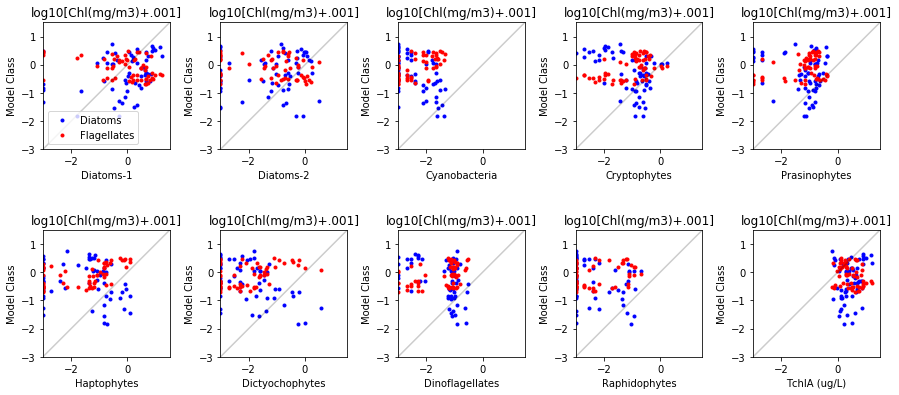

In [32]:
fig,ax=plt.subplots(2,5,figsize=(15,7))
fig.subplots_adjust(wspace=.4)
ax=ax.flatten()

chplc=('Diatoms-1', 'Diatoms-2','Cyanobacteria','Cryptophytes', 'Prasinophytes', 
       'Haptophytes',  'Dictyochophytes','Dinoflagellates','Raphidophytes','TchlA (ug/L)')

mvar1=Chl_N*data['mod_diatoms']
mvar2=Chl_N*data['mod_flagellates']

for ii in range(0,len(chplc)):
    ax[ii].plot(logt(data.loc[:,[chplc[ii]]].values),logt(mvar1),'.',color='blue',label='Diatoms')
    ax[ii].plot(logt(data.loc[:,[chplc[ii]]].values),logt(mvar2),'.',color='red',label='Flagellates')
    ax[ii].set_ylabel('Model Class')
    ax[ii].set_xlabel(chplc[ii])
    ax[ii].set_title('log10[Chl(mg/m3)+.001]')
    ax[ii].plot((-3,1.5),(-3,1.5),'k-',alpha=.2)
    ax[ii].set_xlim((-3,1.5))
    ax[ii].set_ylim((-3,1.5))
    ax[ii].set_aspect(1)
ax[0].legend()


(-3, 1.5)

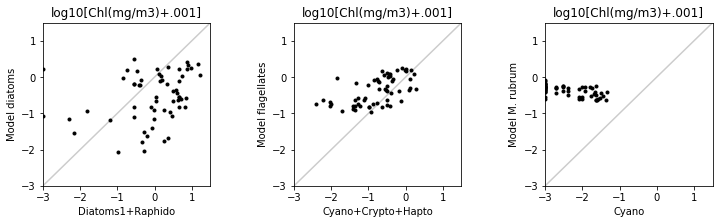

In [33]:
fig,ax=plt.subplots(1,3,figsize=(12,3))
fig.subplots_adjust(wspace=.5)
#ax[0].plot(logt(data['Diatoms-1']+data['Raphidophytes']+.5*data['Cryptophytes']),logt(data['mod_diatoms']),'r.')
ax[0].plot(logt(data['Diatoms-1']+data['Raphidophytes']),logt(data['mod_diatoms']),'k.')
ax[0].set_ylabel('Model diatoms')
ax[0].set_xlabel('Diatoms1+Raphido')
ax[0].set_title('log10[Chl(mg/m3)+.001]')
ax[0].plot((-3,1.5),(-3,1.5),'k-',alpha=.2)
ax[0].set_xlim((-3,1.5))
ax[0].set_ylim((-3,1.5))

ax[1].plot(logt(data['Cyanobacteria']+data['Cryptophytes']+data['Haptophytes']),logt(data['mod_flagellates']),'k.')
ax[1].set_ylabel('Model flagellates')
ax[1].set_xlabel('Cyano+Crypto+Hapto')
ax[1].set_title('log10[Chl(mg/m3)+.001]')
ax[1].plot((-3,1.5),(-3,1.5),'k-',alpha=.2)
ax[1].set_xlim((-3,1.5))
ax[1].set_ylim((-3,1.5))


ax[2].plot(logt(data['Cyanobacteria']),logt(data['mod_ciliates']),'k.')
ax[2].set_ylabel('Model M. rubrum')
ax[2].set_xlabel('Cyano')
ax[2].set_title('log10[Chl(mg/m3)+.001]')
ax[2].plot((-3,1.5),(-3,1.5),'k-',alpha=.2)
ax[2].set_xlim((-3,1.5))
ax[2].set_ylim((-3,1.5))

In [34]:
data['mod_diatoms_chl']=Chl_N*data['mod_diatoms']
data['mod_flagellates_chl']=Chl_N*data['mod_flagellates']
data['mod_ciliates_chl']=Chl_N*data['mod_ciliates']
data['mod_TChl']=data['mod_diatoms_chl']+data['mod_flagellates_chl']+data['mod_ciliates_chl']
data['CCPH']=data['Cyanobacteria']+data['Cryptophytes']+data['Prasinophytes']+data['Haptophytes']
data['DD']=data['Diatoms-1']+data['Diatoms-2']
dfVars=data.loc[:,['Diatoms-1', 'Diatoms-2','Cyanobacteria','Cryptophytes', 'Prasinophytes', 
       'Haptophytes',  'Dictyochophytes','Dinoflagellates','Raphidophytes','DD','CCPH','TchlA (ug/L)',
                   'mod_diatoms_chl','mod_flagellates_chl','mod_ciliates_chl','mod_TChl']]

### Variance-Covariance Matrix

In [35]:
dfVars.cov()

,Diatoms-1,Diatoms-2,Cyanobacteria,Cryptophytes,Prasinophytes,Haptophytes,Dictyochophytes,Dinoflagellates,Raphidophytes,DD,CCPH,TchlA (ug/L),mod_diatoms_chl,mod_flagellates_chl,mod_ciliates_chl,mod_TChl
Diatoms-1,11.421175,-0.244988,-0.017372,-0.166095,0.192180,-0.257041,-0.248096,-0.067514,-0.035472,11.176187,-0.248329,10.576746,1.765120,-1.023518,0.436112,1.177714
Diatoms-2,-0.244988,0.317857,-0.000464,-0.033990,-0.017153,-0.029910,0.169521,0.005536,-0.004185,0.072868,-0.081517,0.162213,0.048711,-0.117579,0.007623,-0.061245
Cyanobacteria,-0.017372,-0.000464,0.000138,0.000296,-0.000160,0.001370,0.001138,0.000220,0.000103,-0.017836,0.001645,-0.014727,-0.006541,0.005645,-0.001559,-0.002455
Cryptophytes,-0.166095,-0.033990,0.000296,0.092097,0.010963,0.012856,-0.009275,0.004147,0.009569,-0.200085,0.116212,-0.079422,-0.093241,0.025687,0.013404,-0.054151
Prasinophytes,0.192180,-0.017153,-0.000160,0.010963,0.010794,0.005614,-0.007196,0.001278,0.001249,0.175026,0.027211,0.197566,-0.001858,0.007582,0.010318,0.016042
Haptophytes,-0.257041,-0.029910,0.001370,0.012856,0.005614,0.083472,-0.004750,0.005934,0.003086,-0.286952,0.103313,-0.179378,-0.118823,0.166335,-0.030455,0.017057
Dictyochophytes,-0.248096,0.169521,0.001138,-0.009275,-0.007196,-0.004750,0.244144,0.016110,-0.000640,-0.078575,-0.020082,0.160922,-0.136795,0.065911,-0.032412,-0.103297
Dinoflagellates,-0.067514,0.005536,0.000220,0.004147,0.001278,0.005934,0.016110,0.004579,0.000703,-0.061978,0.011579,-0.029013,-0.031342,0.025691,-0.003740,-0.009392
Raphidophytes,-0.035472,-0.004185,0.000103,0.009569,0.001249,0.003086,-0.000640,0.000703,0.001707,-0.039657,0.014007,-0.023879,-0.012495,0.006035,0.000349,-0.006111
DD,11.176187,0.072868,-0.017836,-0.200085,0.175026,-0.286952,-0.078575,-0.061978,-0.039657,11.249055,-0.329846,10.738959,1.813830,-1.141097,0.443736,1.116469


### Correlation Coefficient Matrix

In [36]:
dfVars.corr()

,Diatoms-1,Diatoms-2,Cyanobacteria,Cryptophytes,Prasinophytes,Haptophytes,Dictyochophytes,Dinoflagellates,Raphidophytes,DD,CCPH,TchlA (ug/L),mod_diatoms_chl,mod_flagellates_chl,mod_ciliates_chl,mod_TChl
Diatoms-1,1.000000,-0.128580,-0.437807,-0.161949,0.547335,-0.263255,-0.148573,-0.295239,-0.254024,0.986008,-0.147439,0.953608,0.385216,-0.340277,0.503829,0.303837
Diatoms-2,-0.128580,1.000000,-0.070047,-0.198659,-0.292845,-0.183626,0.608533,0.145121,-0.179647,0.038536,-0.290117,0.087668,0.063723,-0.234319,0.052793,-0.094713
Cyanobacteria,-0.437807,-0.070047,1.000000,0.083171,-0.130811,0.403993,0.196230,0.277244,0.212974,-0.452918,0.281133,-0.382196,-0.410898,0.540231,-0.518396,-0.182285
Cryptophytes,-0.161949,-0.198659,0.083171,1.000000,0.347692,0.146626,-0.061852,0.201945,0.763116,-0.196577,0.768368,-0.079742,-0.226605,0.095099,0.172441,-0.155574
Prasinophytes,0.547335,-0.292845,-0.130811,0.347692,1.000000,0.187023,-0.140178,0.181800,0.290879,0.502280,0.525524,0.579410,-0.013190,0.081991,0.387727,0.134618
Haptophytes,-0.263255,-0.183626,0.403993,0.146626,0.187023,1.000000,-0.033271,0.303529,0.258471,-0.296128,0.717501,-0.189178,-0.303328,0.646851,-0.411550,0.051475
Dictyochophytes,-0.148573,0.608533,0.196230,-0.061852,-0.140178,-0.033271,1.000000,0.481847,-0.031336,-0.047414,-0.081550,0.099235,-0.204189,0.149874,-0.256111,-0.182272
Dinoflagellates,-0.295239,0.145121,0.277244,0.201945,0.181800,0.303529,0.481847,1.000000,0.251314,-0.273095,0.343359,-0.130645,-0.341628,0.426582,-0.215785,-0.121013
Raphidophytes,-0.254024,-0.179647,0.212974,0.763116,0.290879,0.258471,-0.031336,0.251314,1.000000,-0.286158,0.680175,-0.176089,-0.223023,0.164093,0.032953,-0.128950
DD,0.986008,0.038536,-0.452918,-0.196577,0.502280,-0.296128,-0.047414,-0.273095,-0.286158,1.000000,-0.197330,0.975612,0.398863,-0.382259,0.516543,0.290232


### Cov matrix with log transformed values:

In [37]:
dflog=pd.DataFrame()
for el in ['Diatoms-1', 'Diatoms-2','Cyanobacteria','Cryptophytes', 'Prasinophytes', 
       'Haptophytes',  'Dictyochophytes','Dinoflagellates','Raphidophytes','CCPH','TchlA (ug/L)',
                   'mod_diatoms_chl','mod_flagellates_chl','mod_ciliates_chl','mod_TChl']:
    dflog[el]=logt(data[el])
dflog.cov()

,Diatoms-1,Diatoms-2,Cyanobacteria,Cryptophytes,Prasinophytes,Haptophytes,Dictyochophytes,Dinoflagellates,Raphidophytes,CCPH,TchlA (ug/L),mod_diatoms_chl,mod_flagellates_chl,mod_ciliates_chl,mod_TChl
Diatoms-1,1.160620,-0.061769,-0.375355,-0.172599,0.066405,-0.610476,-0.282281,-0.262758,-0.196714,-0.155610,0.253038,0.231552,-0.168134,0.082110,-0.007110
Diatoms-2,-0.061769,1.346654,0.051303,-0.136411,-0.375949,0.026979,0.268575,0.074778,-0.060258,-0.175248,-0.008070,0.113976,-0.096261,0.017435,0.005501
Cyanobacteria,-0.375355,0.051303,0.359965,0.131210,0.027474,0.344655,0.286769,0.167806,0.171634,0.104548,-0.108038,-0.223640,0.138542,-0.050724,-0.011687
Cryptophytes,-0.172599,-0.136411,0.131210,0.568062,0.408380,0.226635,0.232425,0.338754,0.283283,0.362281,0.002789,-0.234239,0.136225,-0.019839,-0.043930
Prasinophytes,0.066405,-0.375949,0.027474,0.408380,0.630176,0.180115,0.085997,0.224307,0.190081,0.408052,0.085243,-0.146204,0.111221,-0.003042,-0.009458
Haptophytes,-0.610476,0.026979,0.344655,0.226635,0.180115,1.128340,0.280315,0.269602,0.305335,0.349696,-0.119446,-0.165374,0.211183,-0.051049,0.039209
Dictyochophytes,-0.282281,0.268575,0.286769,0.232425,0.085997,0.280315,0.860654,0.362032,0.219314,0.121753,-0.065282,-0.308791,0.166519,-0.057367,-0.025779
Dinoflagellates,-0.262758,0.074778,0.167806,0.338754,0.224307,0.269602,0.362032,0.556377,0.234927,0.237094,-0.053056,-0.220439,0.112609,-0.026189,-0.017930
Raphidophytes,-0.196714,-0.060258,0.171634,0.283283,0.190081,0.305335,0.219314,0.234927,0.637940,0.214979,-0.045417,-0.138944,0.082189,-0.005957,-0.010138
CCPH,-0.155610,-0.175248,0.104548,0.362281,0.408052,0.349696,0.121753,0.237094,0.214979,0.360380,0.017281,-0.143561,0.116679,-0.014705,-0.006459


### Corr Coeff matrix with log transformed values:

In [38]:
dflog.corr()

,Diatoms-1,Diatoms-2,Cyanobacteria,Cryptophytes,Prasinophytes,Haptophytes,Dictyochophytes,Dinoflagellates,Raphidophytes,CCPH,TchlA (ug/L),mod_diatoms_chl,mod_flagellates_chl,mod_ciliates_chl,mod_TChl
Diatoms-1,1.000000,-0.049408,-0.580720,-0.212567,0.077647,-0.533463,-0.282438,-0.326984,-0.228612,-0.240610,0.672901,0.314654,-0.411824,0.521460,-0.042186
Diatoms-2,-0.049408,1.000000,0.073686,-0.155964,-0.408103,0.021886,0.249473,0.086390,-0.065012,-0.251561,-0.019923,0.143785,-0.218889,0.102795,0.030301
Cyanobacteria,-0.580720,0.073686,1.000000,0.290160,0.057685,0.540796,0.515214,0.374967,0.358164,0.290273,-0.515892,-0.545694,0.609329,-0.578432,-0.124522
Cryptophytes,-0.212567,-0.155964,0.290160,1.000000,0.682551,0.283080,0.332407,0.602563,0.470579,0.800695,0.010603,-0.454980,0.476937,-0.180091,-0.372588
Prasinophytes,0.077647,-0.408103,0.057685,0.682551,1.000000,0.213598,0.116772,0.378814,0.299791,0.856258,0.307637,-0.269624,0.369706,-0.026215,-0.076158
Haptophytes,-0.533463,0.021886,0.540796,0.283080,0.213598,1.000000,0.284454,0.340266,0.359887,0.548391,-0.322154,-0.227918,0.524613,-0.328800,0.235954
Dictyochophytes,-0.282438,0.249473,0.515214,0.332407,0.116772,0.284454,1.000000,0.523176,0.295980,0.218617,-0.201600,-0.487283,0.473643,-0.423075,-0.177631
Dinoflagellates,-0.326984,0.086390,0.374967,0.602563,0.378814,0.340266,0.523176,1.000000,0.394328,0.529489,-0.203778,-0.432648,0.398372,-0.240213,-0.153657
Raphidophytes,-0.228612,-0.065012,0.358164,0.470579,0.299791,0.359887,0.295980,0.394328,1.000000,0.448360,-0.162906,-0.254672,0.271535,-0.051028,-0.081137
CCPH,-0.240610,-0.251561,0.290273,0.800695,0.856258,0.548391,0.218617,0.529489,0.448360,1.000000,0.082473,-0.350097,0.512875,-0.167587,-0.068780


### New groups Model-Obs Comparison:

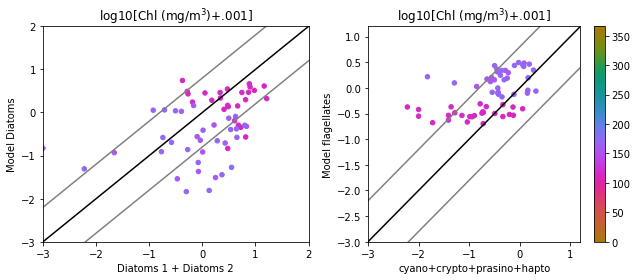

In [39]:
thresh=.8
msize=20
fig,ax=plt.subplots(1,2,figsize=(9,4))
m=ax[0].scatter(logt(data['DD']),logt(data['mod_diatoms_chl']),
          c=data['yd'],s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
m=ax[1].scatter(logt(data['CCPH']),logt(data['mod_flagellates_chl']),
          c=data['yd'],s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[0].set_xlim(-3,2)
ax[0].set_ylim(-3,2)
ax[1].set_xlim(-3,1.2)
ax[1].set_ylim(-3,1.2)
ax[0].set_xlabel('Diatoms 1 + Diatoms 2')
ax[0].set_ylabel('Model Diatoms')
ax[0].set_title('log10[Chl (mg/m$^3$)+.001]')
ax[1].set_xlabel('cyano+crypto+prasino+hapto')
ax[1].set_ylabel('Model flagellates')
ax[1].set_title('log10[Chl (mg/m$^3$)+.001]')
ax[0].plot((-3,2),(-3+thresh,2+thresh),'-',color='grey')
ax[0].plot((-3,2),(-3-thresh,2-thresh),'-',color='grey')
ax[1].plot((-3,2),(-3+thresh,2+thresh),'-',color='grey')
ax[1].plot((-3,2),(-3-thresh,2-thresh),'-',color='grey')
ax[0].plot((-3,2),(-3,2),'k-')
ax[1].plot((-3,1.2),(-3,1.2),'k-')
plt.tight_layout()
fig.colorbar(m,ax=ax[1])

Diatoms/DD


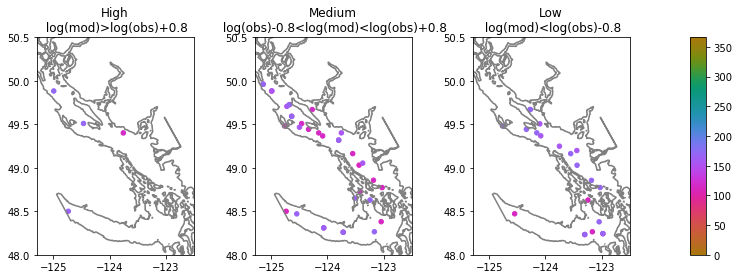

In [40]:
print('Diatoms/DD')
fig,ax=plt.subplots(1,4,figsize=(12,4),gridspec_kw={'width_ratios': [1,1,1,.1],'wspace':.5},)
for iax in ax[0:3]:
    iax.contour(navlon,navlat,tmask[0,:,:],levels=[0.5,],colors='gray')
    iax.set_xlim(-125.3,-122.5)
    iax.set_ylim(48,50.5)
ihi=logt(data['mod_diatoms_chl'])>(logt(data['DD'])+thresh)
ilo=logt(data['mod_diatoms_chl'])<(logt(data['DD'])-thresh)
idata=data.loc[(data.DD>=0)&ihi]
ax[0].scatter(idata.Lon,idata.Lat,c=idata.yd,s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[0].set_title('High\n log(mod)>log(obs)+'+str(thresh))
idata=data.loc[(data.DD>=0)&(~ihi)&(~ilo)]
ax[1].scatter(idata.Lon,idata.Lat,c=idata.yd,s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[1].set_title('Medium\n log(obs)-'+str(thresh)+'<log(mod)<log(obs)+'+str(thresh))
idata=data.loc[(data.DD>=0)&ilo]
m=ax[2].scatter(idata.Lon,idata.Lat,c=idata.yd,s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[2].set_title('Low\n log(mod)<log(obs)-'+str(thresh));
fig.colorbar(m,cax=ax[3]);

Flagellates/CCPH


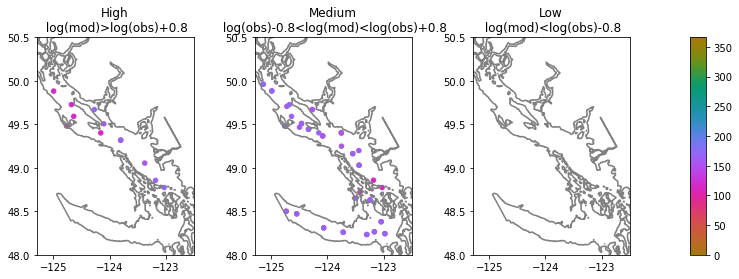

In [41]:
print('Flagellates/CCPH')
fig,ax=plt.subplots(1,4,figsize=(12,4),gridspec_kw={'width_ratios': [1,1,1,.1],'wspace':.5},)
for iax in ax[0:3]:
    iax.contour(navlon,navlat,tmask[0,:,:],levels=[0.5,],colors='gray')
    iax.set_xlim(-125.3,-122.5)
    iax.set_ylim(48,50.5)
ihi=logt(data['mod_flagellates_chl'])>(logt(data['CCPH'])+thresh)
ilo=logt(data['mod_flagellates_chl'])<(logt(data['CCPH'])-thresh)
idata=data.loc[(data.CCPH>=0)&ihi]
ax[0].scatter(idata.Lon,idata.Lat,c=idata.yd,s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[0].set_title('High\n log(mod)>log(obs)+'+str(thresh))
idata=data.loc[(data.CCPH>=0)&(~ihi)&(~ilo)]
ax[1].scatter(idata.Lon,idata.Lat,c=idata.yd,s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[1].set_title('Medium\n log(obs)-'+str(thresh)+'<log(mod)<log(obs)+'+str(thresh))
idata=data.loc[(data.CCPH>=0)&ilo]
m=ax[2].scatter(idata.Lon,idata.Lat,c=idata.yd,s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[2].set_title('Low\n log(mod)<log(obs)-'+str(thresh));
fig.colorbar(m,cax=ax[3]);

### Diatom fraction

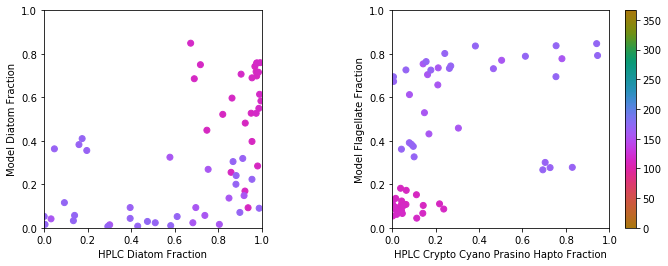

In [42]:
fig,ax=plt.subplots(1,2,figsize=(12,4))
diatFracMod=data['mod_diatoms']/(data['mod_diatoms']+data['mod_flagellates']+data['mod_ciliates'])
diatFracObs=data['DD']/data['TchlA (ug/L)']
m=ax[0].scatter(diatFracObs,diatFracMod,
          c=data['yd'],cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[0].set_xlabel('HPLC Diatom Fraction')
ax[0].set_ylabel('Model Diatom Fraction')
ax[0].set_xlim((0,1))
ax[0].set_ylim((0,1))
flFracMod=data['mod_flagellates']/(data['mod_diatoms']+data['mod_flagellates']+data['mod_ciliates'])
CCPHFracObs=data['CCPH']/data['TchlA (ug/L)']
m=ax[1].scatter(CCPHFracObs,flFracMod,
          c=data['yd'],cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[1].set_xlabel('HPLC Crypto Cyano Prasino Hapto Fraction')
ax[1].set_ylabel('Model Flagellate Fraction')
ax[1].set_xlim((0,1))
ax[1].set_ylim((0,1))
ax[0].set_aspect(1)
ax[1].set_aspect(1)

fig.colorbar(m)

In [43]:
#Reminder:
np.random.seed(42)
df = pd.DataFrame(np.random.randn(1000, 4),columns=['a', 'b', 'c','d'])
df['a+b+c']=.2*df['a']+.3*df['b']+.45*df['c']

In [44]:
df.cov()

,a,b,c,d,a+b+c
a,0.929140,0.007946,-0.037053,-0.022301,0.171538
b,0.007946,1.023910,-0.032939,0.004689,0.293940
c,-0.037053,-0.032939,1.012188,0.034186,0.438192
d,-0.022301,0.004689,0.034186,1.013977,0.012330
a+b+c,0.171538,0.293940,0.438192,0.012330,0.319676


In [45]:
df.corr()

,a,b,c,d,a+b+c
a,1.000000,0.008146,-0.038208,-0.022976,0.314749
b,0.008146,1.000000,-0.032355,0.004602,0.513774
c,-0.038208,-0.032355,1.000000,0.033745,0.770334
d,-0.022976,0.004602,0.033745,1.000000,0.021657
a+b+c,0.314749,0.513774,0.770334,0.021657,1.000000


In [46]:
A=np.vstack([df['a'],df['b'],df['c'],df['d'],np.ones(np.shape(df['a']))]).T
b=df['a+b+c']
m=np.linalg.lstsq(A,b,rcond=None)[0]
print(m)

[ 2.00000000e-01  3.00000000e-01  4.50000000e-01  1.52655666e-16
 -1.04083409e-16]
